# Group number: 17

- Sameera Sandaruwan, s1014012
- Mohit Jethwani, s1019474


**SOW-MKI49: Neural Information Processing Systems**

**Assignment 5: Neural Decoding**

**Total points: 100**

**Author: Umut**

In this assignment, you will implement a neural decoder for reconstructing perceived stimuli from brain responses. We will be using the dataset that was previously used in a number of papers. These papers along with additional lecture notes on neural decoding can be found in Brightspace. You can refer them for more details on the dataset and/or the method.

The dataset contains fMRI data acquired from the early visual cortex of one subject as the subject was presented with 100 grayscale images of handwritten sixes and nines (50 sixes and 50 nines). The fMRI data has been realigned and slice time corrected. Furthermore, stimulus specific response amplitudes have been estimated with a general linear model.

Let's first familiarize ourselves with the dataset. It contains a number of variables:

* **X** -> This is a 100 x 784 matrix. The $i^{th}$ row contains the pixel values of the stimulus that was presented in the $i^{th}$ trial of the experiment. Note that the stimuli are 28 pixel x 28 pixel images, which were reshaped to 1 x 784 vectors.

* **Y** -> This is a 100 x 3092 matrix. The $i^{th}$ row contains the voxel values of the responses that were measured in the $i^{th}$ trial of the experiment.

* **X_prior** -> This is a 2000 x 784 matrix. Each row contains the pixel values of a different stimulus, which was not used in the experiment. Note that the stimuli are 28 pixel x 28 pixel images, which were reshaped to 1 x 784 vectors.

Note: In the remainder of this document, we will use **x** for referring to a 784 x 1 stimulus vector and **y** for referring to a 3092 x 1 response vector.

<span style="color:red">

## Questions

* What is X_prior?


* Why is Y has 3092 values per stimuli?

3092 Voxel values taken from different parts of the brain.

</span>

--- 

<span style="color:blue">

## Learning Points

* Discriminative models
* Ridge regression (https://en.wikipedia.org/wiki/Tikhonov_regularization)
* 

</span>

## Task 1 (10 points)

* Load the dataset.
* Visualize some of the stimuli.
* Normalize X and Y to have zero mean and unit variance. Tip: Recall that normalization means subtracting the mean of each pixel/voxel from itself and dividing it by its standard deviation. You can use zscore function.
* Split X and Y in two parts called X_training and X_test, and Y_training and Y_test. The training set should contain 80 stimulus-response pairs (40 pairs for sixes and 40 pairs for nines). The test set should contain 20 stimulus-response pairs (10 pairs for sixes and 10 pairs for nines).

In [42]:
# Imports
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

# support func
def ptype(x):
    print('>> type:',type(x))
def pshape(x):
    if type(x).__module__ == np.__name__:
        print('>> shape:',x.shape)
def pmin(x, name=''):
    if name!='':
        print('\n',name)
    ptype(x)
    pshape(x)
def pall(x):
    pmin(x)
    print('>> data:',x)

>> type: <class 'dict'>
__header__
__version__
__globals__
X
X_prior
Y
anatomical
region_of_interest_label
region_of_interest_mask
stimulus_label
>> type: <class 'numpy.ndarray'>
>> shape: (100, 784)
>> type: <class 'numpy.ndarray'>
>> shape: (2000, 784)
>> type: <class 'numpy.ndarray'>
>> shape: (100, 3092)


Text(0.5, 1.0, 'Voxel values as a signal (3092 - samples)')

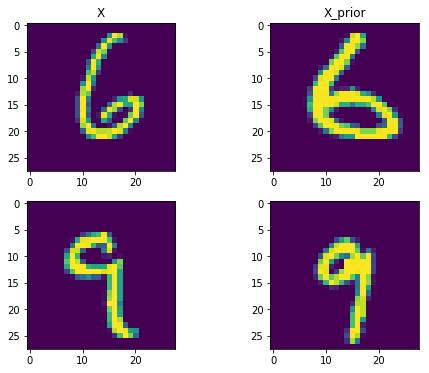

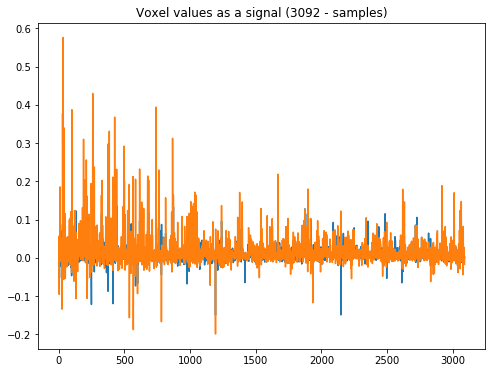

In [2]:
# Load data
dataset = loadmat('dataset.mat')
ptype(dataset)
for key in dataset:
    print(key)
pmin(dataset['X'])
pmin(dataset['X_prior'])
pmin(dataset['Y'])

X_data = dataset['X']
X_prior = dataset['X_prior']
Y_data = dataset['Y']

# Visualize dataset
plt.figure(figsize=(8, 6))
plt.subplot(221)
plt.title('X')
plt.imshow(dataset['X'][49].reshape(28,28).transpose())

plt.subplot(223)
plt.imshow(dataset['X'][50].reshape(28,28).transpose())

plt.subplot(222)
plt.title('X_prior')
plt.imshow(dataset['X_prior'][999].reshape(28,28).transpose())

plt.subplot(224)
plt.imshow(dataset['X_prior'][1000].reshape(28,28).transpose())

plt.figure(figsize=(8, 6))
plt.plot(dataset['Y'][49])
plt.plot(dataset['Y'][50])
plt.title('Voxel values as a signal (3092 - samples)')

In [3]:
# Normalize
'''
Normalize X and Y to have zero mean and unit variance. Tip: Recall that normalization means subtracting the mean 
of each pixel/voxel from itself and dividing it by its standard deviation. You can use zscore function.

1. Find mean and stddv
2. Noramlize [ x = (x-mean)/stddv ]
'''
X_data_mean = np.mean(X_data)
Y_data_mean = np.mean(Y_data)

X_data_stddv = np.std(X_data)
Y_data_stddv = np.std(Y_data)

X_data = (X_data - X_data_mean)/X_data_stddv
Y_data = (Y_data - Y_data_mean)/Y_data_stddv

print( "%.5f | %.5f | %.5f | %.5f" %(np.min(X_data), np.mean(X_data), np.max(X_data), np.std(X_data)))
print( "%.5f | %.5f | %.5f | %.5f" %(np.min(Y_data), np.mean(Y_data), np.max(Y_data), np.std(Y_data)))


-0.42567 | -0.00000 | 2.81088 | 1.00000
-14.33350 | 0.00000 | 23.41943 | 1.00000


In [4]:
# Split
'''Split X and Y in two parts called X_training and X_test, and Y_training and Y_test. The training set should contain 
80 stimulus-response pairs (40 pairs for sixes and 40 pairs for nines). The test set should contain 20 
stimulus-response pairs (10 pairs for sixes and 10 pairs for nines).'''

X_training = np.concatenate((X_data[:40], X_data[50:90]), axis=0)
X_test = np.concatenate((X_data[40:50], X_data[90:100]), axis=0)
pmin(X_test)
Y_training = np.concatenate((Y_data[:40], Y_data[50:90]), axis=0)
Y_test = np.concatenate((Y_data[40:50], Y_data[90:100]), axis=0)

>> type: <class 'numpy.ndarray'>
>> shape: (20, 784)


## Discriminative models

Our goal is to solve the problem of reconstructing $x$ from $y$. One possible approach to solve this problem is to use a *discriminative* model. Discriminative models predict $x$ as a function of $y$. That is:

$$x = f(y) $$

We will assume that $f$ is a linear function. That is:

$$x = B'y$$

$f$ can be seen as a very simple linear neural network comprising one layer of weights (i.e., **B**). We can estimate **B** in close form with **ridge regression**(https://en.wikipedia.org/wiki/Tikhonov_regularization). That is:

**B** = inv(**Y**\_training' **Y**\_training + $\lambda$ **I**) **Y**\_training' **X**\_training

$$ B = inv( Y_{train}'\cdot Y_{train} + \lambda \cdot I )\cdot Y_{train}' \cdot X_{train}$$

* $inv$ - inverse matrix
* $\lambda$ - regularization coefficient
* $I$ - $q \times q$ identity matrix

where $\lambda$ is the regularization coefficient, **I** is the $q \times q$ identity matrix, and *q* is the number of voxels (3092). Note that we can safely ignore the <span style="color:red">intercept</span> since we normalized our data to have zero mean and unit variance.

<span style="color:red">

## Questions

* Discriminative models?

The typical discriminative learning approaches include Logistic Regression(LR), Support Vector Machine(SVM), conditional random fields(CRFs)(specified over an undirected graph), and etc.

https://en.wikipedia.org/wiki/Discriminative_model

* What is $inv$ here?

Inverse matrix


</span>

## Task 2  (15 points)

* Estimate **B** on the training set. Tip: Normally, you should use cross validation to estimate $\lambda$. For simplicity, you can assume that $\lambda = 10^{-6}$.
* Reconstruct **x** from **y** in the test set.
* Visualize the reconstructions.

In [5]:
###3092
lmda = 10e-6
B = np.matmul(np.linalg.inv( np.matmul(Y_training.T,Y_training) + lmda*np.identity(3092) ), np.matmul(Y_training.T,X_training))
pmin(B)

>> type: <class 'numpy.ndarray'>
>> shape: (3092, 784)


In [6]:
y_test = Y_test.T
X_est = np.matmul(B.T, y_test).T

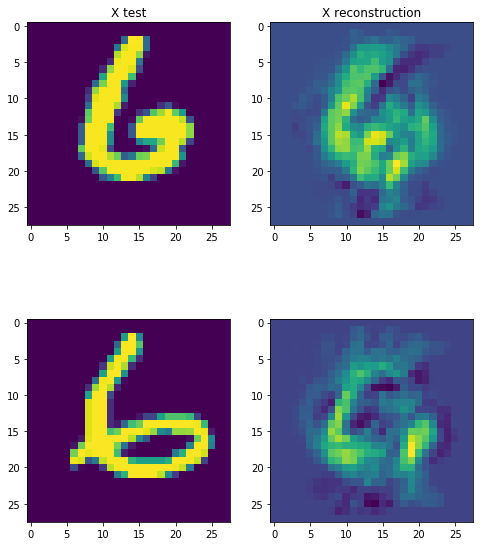

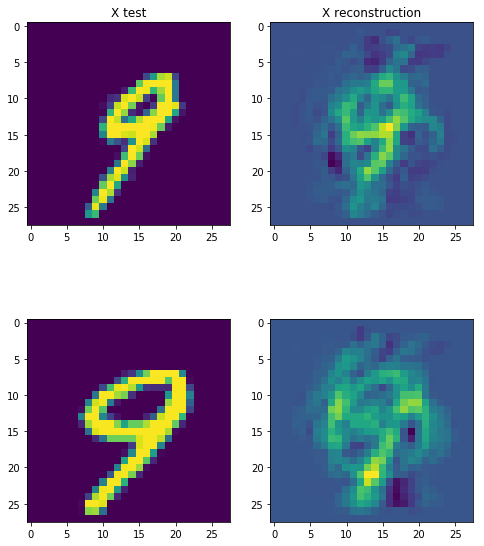

In [7]:
# Visualize reconstruction

def plot2D(gH, data1, data2, title1, title2):
    gW = 2
    subPlotVal = gH*100 + gW*10
#     print(subPlotVal)
    plt.figure(figsize=(8, 10))
    for n in range(0, gW*gH, 2):
        id1 = n+1
        id2 = n+2
        
        plt.subplot(subPlotVal+id1)
        if n==0:
            plt.title(title1)
        plt.imshow(data1[n].reshape(28,28).transpose())
    

        plt.subplot(subPlotVal+id2)
        if n==0:
            plt.title(title2)
        plt.imshow(data2[n].reshape(28,28).transpose())
    
plot2D(2, X_test[:10], X_est[:10], 'X test', 'X reconstruction')
plot2D(2, X_test[10:20], X_est[10:20], 'X test', 'X reconstruction')

## Generative model

Another possible approach to solve the problem of reconstructing **x** from **y** is to use a *generative* model and invert it with Bayes' rule. We reformulate the problem as finding the most probable **x** that could have caused **y**. That is:

argmax_**x** P(**x** | **y**)

$$ argmax_x P(x|y) $$

where $P(x|y)$ is called the posterior (probability of the stimulus being **x** if the observation is **y**). In other words, we have to define the posterior, estimate its parameters and find the argument that maximizes it, which will be the reconstruction of **x** from **y**. While, this may seem daunting, it actually has a simple solution. 

The posterior assigns a probability to an event by combining our observations and beliefs about it, and can be decomposed with Bayes' rule as the product of how likely our observations are given the event **[likelihod]** (probability of observing **y** if the stimulus is **x**) and how likely the event is independent of our observations **[prior]** (probability of the stimulus being **x**). That is:

P(**x** | **y**) ~ P(**y** | **x**) * P(**x**)
$$ P(x|y) \~ P(y|x)\cdot P(x) \tag{1}$$
where P(**y** | **x**) is called the likelihood and P(x) is called the prior.

We will assume that the **likelihood** and the **prior** are ***multivariate Gaussian distributions.***

A Gaussian is characterized by two parameters: a mean vector and a covariance matrix. In the case of the **[likelihood]**, the mean of the Gaussian is given by:

**mu**\_likelihood = **B'** **x**
$$ \mu_{likelihood} = B'\cdot x $$

As before, we can estimate **B** in close form with ridge regression:

**B** = inv(**X**\_training' **X**\_training + lambda **I**) **X**\_training' **Y**\_training

$$ B = inv( X_{train}'\cdot X_{train} + \lambda \cdot I )\cdot X_{train}' \cdot Y_{train}$$

where $\lambda$ is the regularization coefficient, I is the $p \cdot p$ identity matrix, and $p$ (784) is the number of pixels. The covariance matrix of the likelihood is given by:

**Sigma**_likelihood = diag(E[||**y** - **B'** **x**|| ^ 2]). 

$$ \sigma_{likelihood} = diag( E[ || y - B'\cdot x ||^{2} ] ) $$
$$ \sigma_{likelihood} = diag( E[ || y - \mu_{likelihood}(mean) ||^{2} ] ) $$


In the case of the prior, the mean of the Gaussian is given by:

**mu**\_prior = **0** (which is a vector of zeros)

$$ \mu_{prior} = [0] $$

The covariance matrix of the prior is given by:

**Sigma**\_prior = **X**\_prior' * **X**\_prior / (n - 1)

$$ \sigma_{prior} = \frac{X_{prior}'\cdot X_{prior}}{n-1} $$

where n is the length of **X**\_prior.

## Main Points

1. Define **Posterior**
2. Estimate it's parameters
3. Find arg ($y$) that maximizes Posterior - which will be the reconstruction of **x** from **y**

### Multivariate Gaussian Distributions (MGD)

<img src="https://upload.wikimedia.org/wikipedia/commons/8/8e/MultivariateNormal.png" alt="" width="500">

[https://en.wikipedia.org/wiki/Multivariate_normal_distribution]

Both **Likelihood** and **Prior** have **MGDs**. One axis with **mean** and the other axis with **std**.
E.g. mean_prior => (1,784), sigma_prior => (1,784) [Pixel wise mean and std]

* Normalize everything (pixels and voxels)
* Use log...soft.. INSTEAD of inverse. Inverse lead to instability

## Task 3 (20 points)

* Estimate **B** on the training set. Tip: Normally, you should use cross-validation to estimate lambda and Sigma_likelihood. For simplicity, you can assume that lambda = 10 ^ -6 and Sigma_likelihood = 10 ^ -3 **I**.
* Estimate **Sigma**\_prior. Tip: Add 10 ^ -6 to the diagonal of Sigma_prior for regularization.
* Visualize **Sigma**\_prior. Can you explain what it shows?

In [21]:
# Estimate B
lmda = 10e-6
B = np.matmul(np.linalg.inv( np.matmul(X_training.T,X_training) + lmda*np.identity(784) ), 
              np.matmul(X_training.T,Y_training))
pmin(B.T)
pmin(X_training.T)

>> type: <class 'numpy.ndarray'>
>> shape: (3092, 784)
>> type: <class 'numpy.ndarray'>
>> shape: (784, 80)



 mu_likelihood
>> type: <class 'numpy.ndarray'>
>> shape: (80, 3092)

 sigma_likelihood
>> type: <class 'numpy.ndarray'>
>> shape: (784, 784)

 X_prior
>> type: <class 'numpy.ndarray'>
>> shape: (2000, 784)

 mu_likelihood
>> type: <class 'numpy.ndarray'>
>> shape: (80, 3092)

 sigma_prior
>> type: <class 'numpy.ndarray'>
>> shape: (784, 784)


Text(0.5, 1.0, 'sigma_prior')

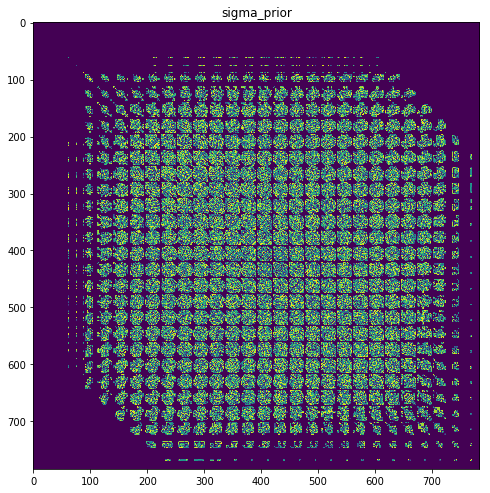

In [44]:

# mu_likelihood
mu_likelihood = np.matmul(B.T, X_training.T).T
pmin(mu_likelihood, 'mu_likelihood')
# Sigma_likelihood

sigma_likelihood = np.sum(np.square(Y_training - mu_likelihood))*np.identity(784)
sigma_likelihood = 10e-3*np.identity(784)
pmin(sigma_likelihood, 'sigma_likelihood')

# mu_prior
mu_prior = 0

# sigma_prior
pmin(X_prior, 'X_prior')
sigma_prior = np.matmul(X_prior.T, X_prior)/(784.0-1.0) #+ lmda*np.identity(784)
pmin(mu_likelihood, 'mu_likelihood')
pmin(sigma_prior, 'sigma_prior')
plt.figure(figsize=(8, 10))
plt.imshow(sigma_prior)
plt.title('sigma_prior')

/home/sameera/anaconda3/envs/NIPS/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


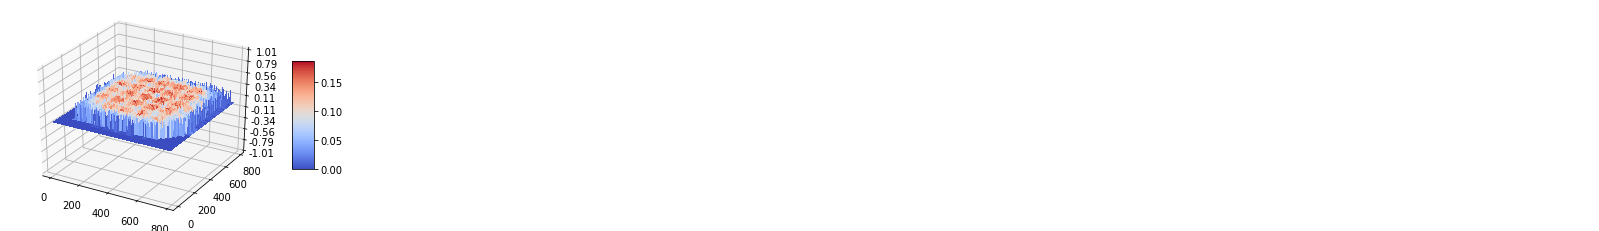

In [17]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

X, Y = np.meshgrid(np.arange(0, 784, 1), np.arange(0, 784, 1))
Z = sigma_prior

# pmin(X)
# pmin(Y)
# pmin(Z)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

fig.show()
fig.savefig('books_read.png')

Having defined the likelihood and the prior as Gaussians, we can derive the posterior by multiplying them. It turns out that the product of two Gaussians is another Gaussian, whose mean vector is given by:

mu\_posterior = inv(inv(Sigma\_prior)[784,784] + B[784,3092] inv(Sigma\_likelihood)[3092,3092] B'[3092,784]) B[784,3092] * inv(Sigma\_likelihood)[3092,3092] y[784,1]

We are almost done. Recall that the reconstruction of **x** from **y** is the argument that maximizes the posterior, which we derived to be a Gaussian. We will be completely done once we answer the following question: What is the argument that maximizes a Gaussian?

.  
.  
.  
.  
.  
.

The answer is its mean vector, which is the solution of our initial problem. That is:

argmax_**x** P(**x** | **y**) =  
**mu**\_posterior =  
inv(inv(**Sigma**\_prior) + **B** inv(**Sigma**\_likelihood) **B**') **B** * inv(**Sigma**\_likelihood) **y**

Now, we can plug any **y** in the above equation and reconstruct the most probable **x** that could have caused it.


## Task 4 (25 points)

- Reconstruct **x** from **y** in the test set.
- Visualize the reconstructions.
- Compare the reconstructions with the earlier reconstructions. Which one is better? Why? Can you think of ways to improve the results?

In [12]:
###

Now the real fight begins! You might have already realized that the second approach is very similar to the one in the face reconstruction paper that we have discussed in the last lecture. The main difference is how the stimuli are encoded. So far, we have been encoding the stimuli with an identity transformation:

**mu**\_likelihood = **B'** g(**x**)

where g(**x**) = **x**

In the paper, they are encoded as the features extracted from a DNN:

**mu**\_likelihood = **B'** DNN(**x**)

Similarly, we have been decoding the responses with MAP estimation of the stimuli:

g ^ -1(argmax_g(**x**) P(g(**x**) | **y**))

where g ^ -1(**y**) = **y**

In the paper, they are decoded with MAP estimation of the features followed by an inverse DNN:

DNN ^ -1(argmax_DNN(**x**) P(DNN(**x**) | **y**))

## Task 5 (30 points)

- Train a simple DNN for digit classification on the MNIST dataset.
- Select an indermediate layer of the DNN as your feature extractor.
- Train another simple DNN to invert the first DNN. That is, it should transform features extracted by the selected layer of the first DNN to stimuli.
- Repeat Task 3 but use the trained DNNs instead of identity transformation.

In [13]:
###